In [4]:
#%%
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import to_categorical
from keras.models import Sequential, load_model
from keras.layers import Dense, Dropout, Flatten, Activation
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from keras.optimizers import Adam
from keras.callbacks import LearningRateScheduler
from keras.callbacks import EarlyStopping
from tensorflow.keras.datasets import mnist
import math
from keras.regularizers import l2
import os
cwd = os.getcwd()

In [6]:
#%%
(x_train, y_train), (x_test, y_test) = mnist.load_data()

#first param in reshape is number of examples. We can pass -1 here as we want numpy to figure that out by itself

#reshape(examples, height, width, channels)
x_train = x_train.reshape(-1, 28, 28, 1)
x_test = x_test.reshape(-1, 28, 28, 1)

# Printing the shape
print('x_train:', x_train.shape)
print('y_train:', y_train.shape)
print('x_test:', x_test.shape)
print('y_test:', y_test.shape)

11490434/11490434 [==============================] - 1s 0us/step
x_train: (60000, 28, 28, 1)
y_train: (60000,)
x_test: (10000, 28, 28, 1)
y_test: (10000,)


In [7]:
datagen = ImageDataGenerator(
            featurewise_center=False,  # set input mean to 0 over the dataset
            samplewise_center=False,  # set each sample mean to 0
            featurewise_std_normalization=False,  # divide inputs by std of the dataset
            samplewise_std_normalization=False,  # divide each input by its std
            zca_whitening=False,  # apply ZCA whitening
            rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
            zoom_range = 0.1, # Randomly zoom image
            width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
            height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
            horizontal_flip=False,  # randomly flip images
            vertical_flip=False)  # randomly flip images

#%%
#convert values to float as result will be a float. If not done vals are set to zero

x_train = x_train.astype("float32")/255
x_test = x_test.astype("float32")/255

#fitting the ImageDataGenerator
datagen.fit(x_train)

#%%
#notice num_classes is set to 10 as we have 10 different labels
y_train = to_categorical(y_train, num_classes=10)
y_test = to_categorical(y_test, num_classes=10)

In [8]:
#%%
model = Sequential([
# Layer 1
Conv2D(filters = 32, kernel_size = 5, strides = 1, activation = 'relu', input_shape = (28,28,1), kernel_regularizer=l2(0.0005)),
# Layer 2
Conv2D(filters = 32, kernel_size = 5, strides = 1, use_bias=False),
# Layer 3
BatchNormalization(),
# — — — — — — — — — — — — — — — — #
Activation('relu'),
MaxPooling2D(pool_size = 2, strides = 2),
Dropout(0.25),
# — — — — — — — — — — — — — — — — #
# Layer 3
Conv2D(filters = 64, kernel_size = 3, strides = 1, activation = 'relu', kernel_regularizer=l2(0.0005)),
# Layer 4
Conv2D(filters = 64, kernel_size = 3, strides = 1, use_bias=False),
# Layer 5
BatchNormalization(),
# — — — — — — — — — — — — — — — — #
Activation('relu'),
MaxPooling2D(pool_size = 2, strides = 2),
Dropout(0.25),
Flatten(),
# — — — — — — — — — — — — — — — — #
# Layer 6
Dense(units = 256, use_bias=False),
# Layer 7
BatchNormalization(),
# — — — — — — — — — — — — — — — — #
Activation('relu'),
# — — — — — — — — — — — — — — — — #
# Layer 8
Dense(units = 128, use_bias=False),
# Layer 9
BatchNormalization(),
# — — — — — — — — — — — — — — — — #
Activation('relu'),
# — — — — — — — — — — — — — — — — #
# Layer 10
Dense(units = 84, use_bias=False),
# Layer 11
BatchNormalization(),
# — — — — — — — — — — — — — — — — #
Activation('relu'),
Dropout(0.25),
# — — — — — — — — — — — — — — — — #
# Output
Dense(units = 10, activation = 'softmax')
])

In [9]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 24, 24, 32)        832       
                                                                 
 conv2d_1 (Conv2D)           (None, 20, 20, 32)        25600     
                                                                 
 batch_normalization (Batch  (None, 20, 20, 32)        128       
 Normalization)                                                  
                                                                 
 activation (Activation)     (None, 20, 20, 32)        0         
                                                                 
 max_pooling2d (MaxPooling2  (None, 10, 10, 32)        0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 10, 10, 32)        0

In [14]:
#%%
#Optimizer
optimizer = Adam(lr=0.001, beta_1=0.9, beta_2=0.999 )
#Compiling the model
model.compile(optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"])

#Define LearningRateScheduler
reduce_lr = LearningRateScheduler(lambda x: 1e-3 * 0.9 ** x)
model_checkpoint = tf.keras.callbacks.ModelCheckpoint (filepath=os.path.join(cwd,'models/CNN_2_mnist.h5'),
                                                       monitor='val_accuracy',save_best_only=True, mode="max")
#%%
#defining these prior to model to increase readability and debugging
batch_size = 32
epochs = 50

history = model.fit_generator(datagen.flow(x_train, y_train, batch_size = batch_size), epochs = epochs,
                              validation_data = (x_test, y_test), verbose=1,
                              steps_per_epoch=x_train.shape[0] // batch_size,
                              callbacks = [reduce_lr,model_checkpoint]) #left out early_stopping parameter as it gets better accuracy


Epoch 1/50


<ipython-input-14-7c852288e4b4>:16: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(datagen.flow(x_train, y_train, batch_size = batch_size), epochs = epochs,


1875/1875 [==============================] - 45s 22ms/step - loss: 0.0675 - accuracy: 0.9824 - val_loss: 0.0479 - val_accuracy: 0.9908 - lr: 0.0010
Epoch 2/50
1875/1875 [==============================] - 43s 23ms/step - loss: 0.0667 - accuracy: 0.9845 - val_loss: 0.0332 - val_accuracy: 0.9938 - lr: 9.0000e-04
Epoch 3/50
1875/1875 [==============================] - 43s 23ms/step - loss: 0.0658 - accuracy: 0.9849 - val_loss: 0.0338 - val_accuracy: 0.9934 - lr: 8.1000e-04
Epoch 4/50
1875/1875 [==============================] - 42s 22ms/step - loss: 0.0609 - accuracy: 0.9862 - val_loss: 0.0308 - val_accuracy: 0.9941 - lr: 7.2900e-04
Epoch 5/50
1875/1875 [==============================] - 42s 22ms/step - loss: 0.0592 - accuracy: 0.9871 - val_loss: 0.0326 - val_accuracy: 0.9944 - lr: 6.5610e-04
Epoch 6/50
1875/1875 [==============================] - 42s 22ms/step - loss: 0.0545 - accuracy: 0.9882 - val_loss: 0.0300 - val_accuracy: 0.9948 - lr: 5.9049e-04
Epoch 7/50
1875/1875 [===============

In [16]:
marvin_reloaded = tf.keras.models.load_model('models/CNN_2_mnist.h5')
loss_and_metrics = marvin_reloaded.evaluate(x_test, y_test, verbose=2)

print("Test Loss", loss_and_metrics[0])
print("Test Accuracy", loss_and_metrics[1])


313/313 - 1s - loss: 0.0165 - accuracy: 0.9966 - 1s/epoch - 4ms/step
Test Loss 0.01647542044520378
Test Accuracy 0.9965999722480774


In [17]:
# Let Marvin predict on the test set, so we have some data to evaluate his performance.
predictions = marvin_reloaded.predict([x_test])

# Remember that the prediction of Marvin is a probability distribution over all ten-digit classes
# We want him to assign the digit class with the highest probability to the sample.
predictions = np.argmax(predictions, axis=1)
#pd.DataFrame(predictions)
y_test = np.argmax(y_test,axis=1)

313/313 [==============================] - 1s 4ms/step


<ipython-input-18-91e0c4b2cb49>:15: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(num_cells, num_cells, plot_index + 1)


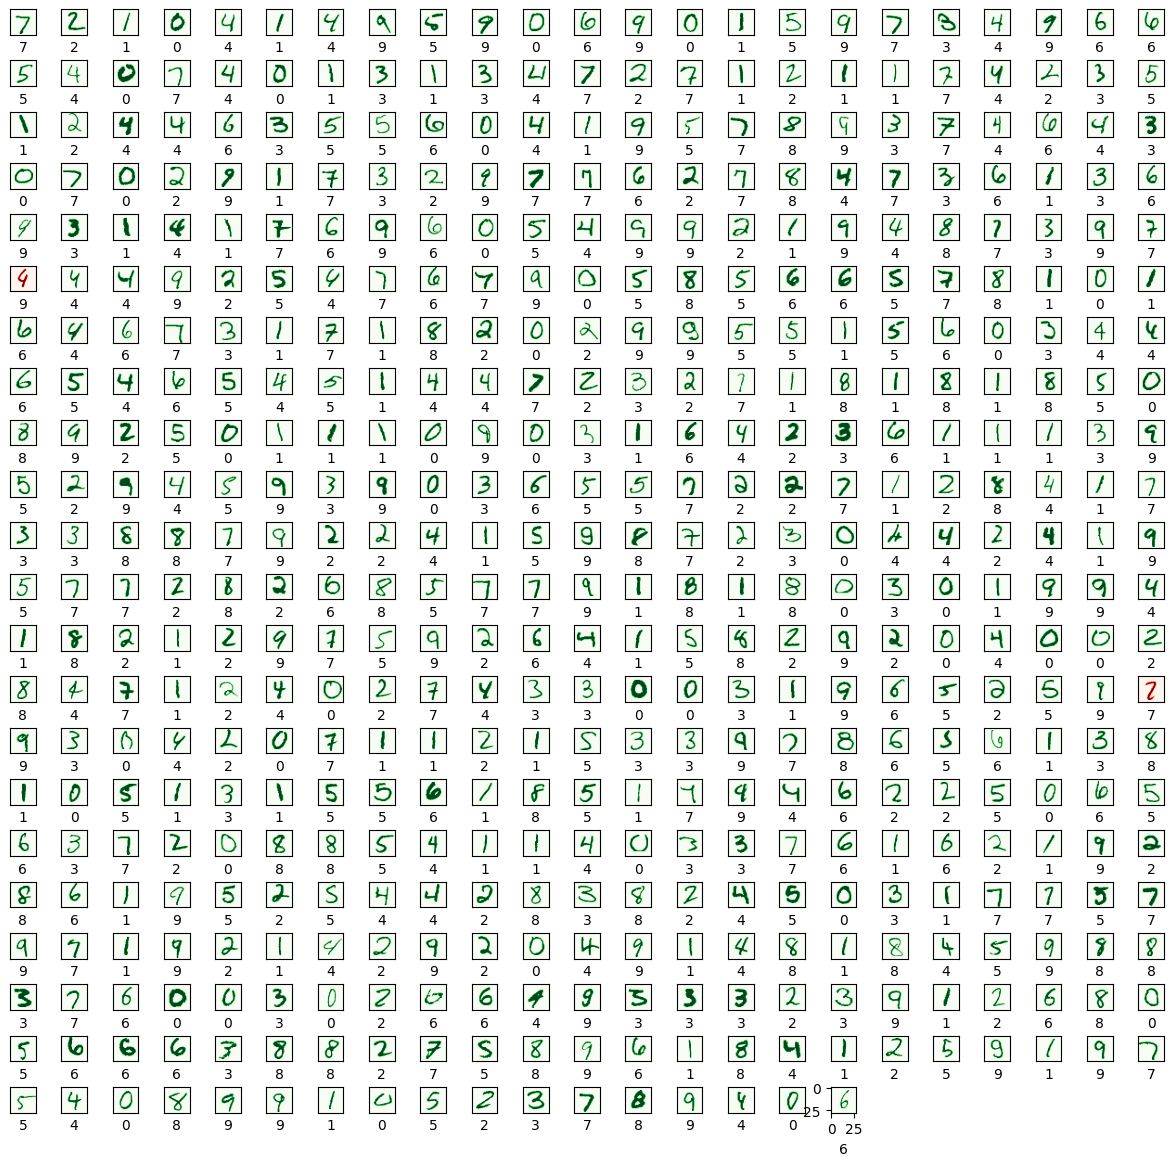

In [18]:
#%%

# Plot for the intuitive approach

numbers_to_display = 500
num_cells = math.ceil(math.sqrt(numbers_to_display))
plt.figure(figsize=(15, 15))

for plot_index in range(numbers_to_display):
    predicted_label = predictions[plot_index]
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    color_map = 'Greens' if predicted_label == y_test[plot_index] else 'Reds'
    plt.subplot(num_cells, num_cells, plot_index + 1)
    plt.imshow(x_test[plot_index].reshape((28, 28)), cmap=color_map)
    plt.xlabel(predicted_label)

plt.subplots_adjust(hspace=1, wspace=0.5)
plt.show()